### main_pretrain

In [87]:
from main_pretrains.main_gpt2 import main_pretrain, GPT2SOH
from data_provider import data_provider
import torch
import torch.optim as optim
import random
import numpy as np

source_set_train, source_loader_train = data_provider(name = 'GOTION', shuffle_flag=True, batch_size=10, flag = 'train')
source_set_test, source_loader_test = data_provider(name = 'GOTION', shuffle_flag=False, batch_size=10, flag = 'test')

# Model parameters
input_dim = 1
gpt2_model_path = './llms'

# Training parameters
mask_ratio = 0.3
num_epochs = 15
LR = 1e-3

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
f_g = GPT2SOH(input_dim, gpt2_model_path, PPA=True, soft_prompt_len=10).to(device)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, f_g.parameters()), lr=LR)
set_seed(0)
# Assuming train_loader and test_loader are already defined
main_pretrain(train_loader= source_loader_train, test_loader= source_loader_test, model=f_g, optimizer=optimizer, device=device, mask_ratio=mask_ratio, num_epochs=num_epochs)
torch.save(f_g.state_dict(), 'saved_models/gpt2+ppa/f_g.pt')

GOTION train 2840
GOTION test 1419
cuda


d:\Applications\Anaconda\envs\batteryML\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


KeyboardInterrupt: 

### prob (PG-SSL)

In [100]:
from main_pretrains.main_gpt2_prob import main_prob
import torch.nn as nn

target_set_train, target_loader_train = data_provider(name = 'CALCE', shuffle_flag=False, batch_size=10, flag = 'train')
target_set_test, target_loader_test = data_provider(name = 'CALCE', shuffle_flag=False, batch_size=10, flag = 'test')

LR = 1e-3
EPOCH = 3

f_g = GPT2SOH(input_dim, gpt2_model_path, PPA=True, soft_prompt_len=10).to(device)
f_g.load_state_dict(torch.load("saved_models/gpt2+ppa/f_g.pt"))

for param in f_g.gpt2.parameters():
    param.requires_grad = False

regressor = nn.Linear(f_g.input_linear.out_features, 1).to(device)
optimizer = optim.AdamW(regressor.parameters(), lr=LR)

set_seed(5)
main_prob(source_loader_train, target_loader_train, combined_training=True, model=f_g, regressor=regressor, optimizer=optimizer, device=device, num_epochs=EPOCH)
torch.save(regressor.state_dict(), 'saved_models/gpt2+ppa/regressor.pt')

CALCE train 1173
CALCE test 637


d:\Applications\Anaconda\envs\batteryML\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Epoch [1/3], Source Loader Loss: 0.024361755003347998
Target Loader - MAE: 0.018559686839580536, RMSE: 0.021763969212770462
Epoch [2/3], Source Loader Loss: 8.527426009197985e-05
Target Loader - MAE: 0.017269670963287354, RMSE: 0.020080847665667534
Epoch [3/3], Source Loader Loss: 3.985497370566419e-05
Target Loader - MAE: 0.016407081857323647, RMSE: 0.01919720508158207


(637,)
(637,)


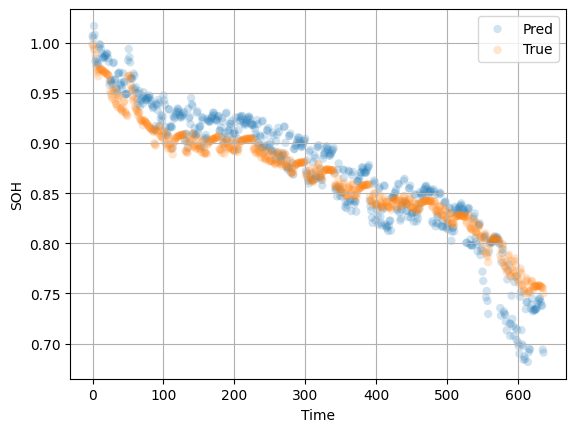

In [101]:
from drawings import drawDegradation
drawDegradation(target_loader_test=target_loader_test, model=f_g, regressor=regressor, device = device, model_name = 'gpt2')

### tta (PPA)

In [144]:
from main_pretrains.main_gpt2_tta import main_tta
from evaluator import evaluate

f_g = GPT2SOH(input_dim, gpt2_model_path, PPA=True, soft_prompt_len=10).to(device)
f_g.load_state_dict(torch.load("saved_models/gpt2+ppa/f_g.pt"))
regressor = nn.Linear(f_g.input_linear.out_features, 1).to(device)
regressor.load_state_dict(torch.load("saved_models/gpt2+ppa/regressor.pt"))

mae, rmse = evaluate(model = f_g, regressor=regressor, target_loader=target_loader_test, device=device, model_name='gpt2')
print(f"(Before TTA) MAE: {mae}, RMSE: {rmse}")

# 冻结GPT-2模型的所有参数
for name, param in f_g.named_parameters():
    if name =='soft_prompt':
        param.requires_grad = True
    else:
        param.requires_grad = True

# for name, param in f_g.gpt2.named_parameters():
#     if not any(layer in name.lower() for layer in ['ln', 'wpe', 'wte']):
#         param.requires_grad = False

# Print trainable and frozen parameters
print("Trainable parameters:")
trainable_params_count = 0
for name, param in f_g.named_parameters():
    if name =='soft_prompt':
        print('PPA params:', param.numel())
    if param.requires_grad:
        print(name)
        trainable_params_count += param.numel()

print("\nFrozen parameters:")
frozen_params_count = 0
for name, param in f_g.named_parameters():
    if not param.requires_grad:
        print(name)
        frozen_params_count += param.numel()

print(f"\nNumber of trainable parameters: {trainable_params_count}")
print(f"Total number of parameters: {trainable_params_count + frozen_params_count}")
print(f"Number of frozen parameters: {frozen_params_count}")


d:\Applications\Anaconda\envs\batteryML\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


(Before TTA) MAE: 0.017048420384526253, RMSE: 0.021097177639603615
Trainable parameters:
PPA params: 7680
soft_prompt
input_linear.weight
input_linear.bias
gpt2.wte.weight
gpt2.wpe.weight
gpt2.h.0.ln_1.weight
gpt2.h.0.ln_1.bias
gpt2.h.0.attn.c_attn.weight
gpt2.h.0.attn.c_attn.bias
gpt2.h.0.attn.c_proj.weight
gpt2.h.0.attn.c_proj.bias
gpt2.h.0.ln_2.weight
gpt2.h.0.ln_2.bias
gpt2.h.0.mlp.c_fc.weight
gpt2.h.0.mlp.c_fc.bias
gpt2.h.0.mlp.c_proj.weight
gpt2.h.0.mlp.c_proj.bias
gpt2.h.1.ln_1.weight
gpt2.h.1.ln_1.bias
gpt2.h.1.attn.c_attn.weight
gpt2.h.1.attn.c_attn.bias
gpt2.h.1.attn.c_proj.weight
gpt2.h.1.attn.c_proj.bias
gpt2.h.1.ln_2.weight
gpt2.h.1.ln_2.bias
gpt2.h.1.mlp.c_fc.weight
gpt2.h.1.mlp.c_fc.bias
gpt2.h.1.mlp.c_proj.weight
gpt2.h.1.mlp.c_proj.bias
gpt2.h.2.ln_1.weight
gpt2.h.2.ln_1.bias
gpt2.h.2.attn.c_attn.weight
gpt2.h.2.attn.c_attn.bias
gpt2.h.2.attn.c_proj.weight
gpt2.h.2.attn.c_proj.bias
gpt2.h.2.ln_2.weight
gpt2.h.2.ln_2.bias
gpt2.h.2.mlp.c_fc.weight
gpt2.h.2.mlp.c_fc.bias


In [145]:
import tracemalloc
optimizer = optim.SGD(filter(lambda p: p.requires_grad, f_g.parameters()), lr=1e-2)

# optimizer = optim.SGD([f_g.soft_prompt], lr=50e-1, momentum=0.9)
set_seed(2)
# mae, rmse = evaluate(model = f_g, regressor=regressor, target_loader=target_loader_test, device=device, model_name='gpt2')
print(f"(Before TTA) MAE: {mae}, RMSE: {rmse}")

tracemalloc.start()
main_tta(target_loader=target_loader_test, model=f_g, regressor=regressor, optimizer=optimizer, device=device, mask_ratio=0.9, num_epochs=1)
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
print(f"Full parameter tuning memory usage: Current = {current / 10**6} MB; Peak = {peak / 10**6} MB")
# mae, rmse = evaluate(model = f_g, regressor=regressor, target_loader=target_loader_test, device=device, model_name='gpt2')
print(f"(After TTA) MAE: {mae}, RMSE: {rmse}")

(Before TTA) MAE: 0.017048420384526253, RMSE: 0.021097177639603615
Epoch [1/1], TTA Reconstruction Loss: 0.029633404839842115
Target Loader - MAE: 0.021234897896647453, RMSE: 0.024814972653985023
Full parameter tuning memory usage: Current = 0.250805 MB; Peak = 0.288624 MB
(After TTA) MAE: 0.017048420384526253, RMSE: 0.021097177639603615
